In [1]:
import numpy as np
from IPython import display

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from datetime import datetime

In [4]:
num_hidden = 100
num_dxs = 200
num_findings = 3000
num_samples = 500

In [5]:
def update_params(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv):
    num_samples, num_hidden = H.shape
    _, num_findings = W.shape
    _, num_dxs = V.shape
    
    Xi = np.sqrt(Sig_H.dot(Sig_W+(W**2))+(H**2).dot(Sig_W)+(H.dot(W))**2)
    Eta2 = diff_op(H.dot(V))**2+ diff_op2((Sig_H+H**2).dot(Sig_V))+np.tensordot(Sig_H,diff_op(V)**2,axes=(1,0)) 
    Eta = np.sqrt(Eta2)
    #Eta = np.sqrt(diff_op2(Sig_H.dot(Sig_V+(V**2))+(H**2).dot(Sig_V)+(H.dot(V))**2))
    
    assert np.isfinite(Xi).all()
    assert np.isfinite(Eta).all()
    
    #L = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv)
    
    
    
    W_ext = np.hstack([W,diff_op(V).reshape([num_hidden,-1])])
    Xi_ext = np.hstack([Xi,Eta.reshape([num_samples,-1])])
    T_ext = np.hstack([X,Y.reshape([num_samples,-1])])
    
    H_T, Sig_H_T = update_weights(T_ext.T,H.T,W_ext.T,Xi_ext.T,H_0.T,Sig_H_0_inv.T)
    H, Sig_H = (H_T.T,Sig_H_T.T)
    
    
    
    W, Sig_W = update_weights(X,W,H,Xi,W_0,Sig_W_0_inv)
    
    #LW = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv)
    
    #print("Computing diff_op")
    #diff_op_mat = diff_op(np.eye(V.shape[1]))
    #print("Computing H_ext")
#     H_ext = np.einsum('ij,klm->ilmjk',H,diff_op_mat).reshape([num_samples,-1])
#     V_resh,Sig_V_resh = update_weights(Y.reshape([-1]),
#                                        V.reshape([-1]),
#                                        H_ext.reshape([-1,len(V.reshape([-1]))]),
#                                        Eta.reshape([-1]),
#                                        V_0.reshape([-1]),
#                                        Sig_V_0_inv.reshape([-1]))
#     V = V_resh.reshape(V.shape)
#     Sig_V = Sig_V_resh.reshape(V.shape)
    V, Sig_V = update_weights_alt(Y,V,H,Eta,V_0,Sig_V_0_inv)
    
    #LV = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv)
    
    #LH = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv)
    
    return (H,Sig_H), (W,Sig_W), (V,Sig_V), (Xi,Eta) #(LH,) #,(L,LW,LV,LH)

def update_weights(T,W,X,Xi,W_0,S_W_0_inv):
    """Update the weight matrix
    T = observed values
    W = weights (at current iteration of VB)
    X = features
    Xi = JJ positions (at current iteration of VB)
    W_0 = prior bias for W
    reg = regularization strength
    
    we assume T ~ Bernouilli(sigmoid(XW))
    returns (W,Sig_W)
    where W are the updated weight values and Sig_W are the current variances of those weight values.
    """
    start_time = datetime.now()
    #print("T: %s, W: %s, X: %s, Xi: %s, W_0: %s" % (T.shape,W.shape,X.shape,Xi.shape,W_0.shape))
    k = (len(X.shape)+len(W.shape)-len(T.shape))//2 # number of indices to contract over.
    #S_W_0_inv = reg*np.ones(W.shape)
    #print("Updating Weights")
    
    assert np.isfinite(Xi).all()
    #print("Computing Lambdoid")
    lamXi = lambdoid(Xi)
    assert np.isfinite(lamXi).all()
    
    #print("k:%d, X: %s, Xi: %s" %(k,X.shape,Xi.shape))
    #print("Computing X2lamXi")
    X2lamXi = np.tensordot((X**2).T,lamXi,k)
    assert np.isfinite(X2lamXi).all()
    
    S_W_inv_ = S_W_0_inv + 2*X2lamXi
    #print("Computing S_W_")
    S_W_ = np.reciprocal(S_W_inv_)
    assert np.isfinite(S_W_).all()
    
    #print("Computing terms1,2")
    term1 = np.tensordot(X.T, T-0.5-2*lamXi*np.tensordot(X,W,k),k)
    term2 = 2*W*X2lamXi
    
    assert np.isfinite(term1).all()
    assert np.isfinite(term2).all()
    
    #print("Computing W_")
    W_ = S_W_*(S_W_0_inv*W_0+term1+term2)
    
    assert np.isfinite(W_).all()
    end_time = datetime.now()
    print("weight update time: %f" % (end_time-start_time).total_seconds())
    return W_, S_W_
    
def update_weights_alt(T,W,XL,Xi,W_0,S_W_0_inv):
    """Update the weight matrix
    T = observed values
    W = weights (at current iteration of VB)
    X = features
    Xi = JJ positions (at current iteration of VB)
    W_0 = prior bias for W
    reg = regularization strength
    
    we assume T ~ Bernouilli(sigmoid(XW))
    returns (W,Sig_W)
    where W are the updated weight values and Sig_W are the current variances of those weight values.
    """
    #print("T: %s, W: %s, XL: %s, Xi: %s, W_0: %s" % (T.shape,W.shape,XL.shape,Xi.shape,W_0.shape))
    k = (len(XL.shape)+len(W.shape)-len(T.shape))//2 # number of indices to contract over.
    #S_W_0_inv = reg*np.ones(W.shape)
    lxl = len(XL.shape)-1
    lw = len(W.shape)-1
    #print("Updating Weights")
    
    assert np.isfinite(Xi).all()
    #print("Computing Lambdoid")
    lamXi = lambdoid(Xi)
    assert np.isfinite(lamXi).all()
    
    #print("k:%d, XL: %s, Xi: %s" %(k,XL.shape,Xi.shape))
    #print("Computing X2lamXi")
    X2lamXi = diff_op2_T(np.tensordot((XL**2).T,Xi,axes=(lxl,0)))
    #X2lamXi = np.tensordot((X**2).T,lamXi,k)
    assert np.isfinite(X2lamXi).all()
    
    #print("k:%d, S_W_0_inv: %s, X2lamXi: %s" %(k,S_W_0_inv.shape,X2lamXi.shape))
    
    S_W_inv_ = S_W_0_inv + 2*X2lamXi
    #print("Computing S_W_")
    S_W_ = np.reciprocal(S_W_inv_)
    assert np.isfinite(S_W_).all()
    
    #print("Computing terms1,2")
    XLWXR = diff_op(np.tensordot(XL,W,axes=(lxl,0)))
    #print("k:%d, XLWXR: %s" %(k,XLWXR.shape))
    term1 = diff_op_T(np.tensordot(XL.T,T-0.5-2*lamXi*(XLWXR),axes=(lxl,0)))
    #print("k:%d, term1: %s" %(k,term1.shape))
    #term1 = np.tensordot(X.T, T-0.5-2*lamXi*np.tensordot(X,W,k),k)
    term2 = 2*W*X2lamXi
    #print("k:%d, term2: %s" %(k,term2.shape))
    
    assert np.isfinite(term1).all()
    assert np.isfinite(term2).all()
    
    #print("Computing W_")
    W_ = S_W_*(S_W_0_inv*W_0+term1+term2)
    
    assert np.isfinite(W_).all()
    return W_, S_W_
    

In [6]:
def diff_op(HV,max_dxs=None):
    num_axis = len(HV.shape)
    HVm1 = np.expand_dims(HV,num_axis)
    HVm2 = np.expand_dims(HV,num_axis-1)
    return np.tile(HVm1,[1]*num_axis+[num_dxs])-np.tile(HVm2,[1]*(num_axis-1)+[num_dxs,1])

def diff_op2(HV,max_dxs=None):
    num_axis = len(HV.shape)
    HVm1 = np.expand_dims(HV,num_axis)
    HVm2 = np.expand_dims(HV,num_axis-1)
    return np.tile(HVm1,[1]*num_axis+[num_dxs])+np.tile(HVm2,[1]*(num_axis-1)+[num_dxs,1])
    
def diff_op_T(HTY):
    num_axis = len(HTY.shape)
    return HTY.sum(axis=num_axis-1)-HTY.sum(axis=num_axis-2)

def diff_op2_T(HTY):
    num_axis = len(HTY.shape)
    return HTY.sum(axis=num_axis-1)+HTY.sum(axis=num_axis-2)

In [7]:
def KLDivergence(m1,Sig1,m2,Sig2):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    d = len(m1)
    Sig2inv = np.linalg.inv(Sig2)
    Sig2invSig1 = Sig2inv.dot(Sig1)
    return 0.5*(-np.linalg.slogdet(Sig2invSig1)[1]-d+np.trace(Sig2invSig1)+(m2-m1).T.dot(Sig2inv.dot(m2-m1)))

def KLDivergence_diag(m1,Sig1,m2,Sig2):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    d = len(m1.flatten())
    Sig2inv = np.reciprocal(Sig2)
    Sig2invSig1 = Sig2inv*Sig1
    return 0.5*(-np.log(Sig2invSig1).sum()-d+Sig2invSig1.sum()+(((m2-m1)**2)*Sig2inv).sum())

def KLDivergence_inv(m1,Sig1,m2,Sig2inv):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    d = len(m1)
    #Sig2inv = np.linalg.inv(Sig2)
    Sig2invSig1 = Sig2inv.dot(Sig1)
    return 0.5*(-np.linalg.slogdet(Sig2invSig1)[1]-d+np.trace(Sig2invSig1)+(m2-m1).T.dot(Sig2inv.dot(m2-m1)))

def KLDivergence_inv_diag(m1,Sig1,m2,Sig2inv):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    #print("Computing KL")
    d = len(m1.flatten())
    #Sig2inv = np.reciprocal(Sig2)
    Sig2invSig1 = Sig2inv*Sig1
    return 0.5*(-np.log(Sig2invSig1).sum()-d+Sig2invSig1.sum()+(((m2-m1)**2)*Sig2inv).sum())

In [8]:
def log_1_add_exp(x):
    mask = x<0
    nmask = np.logical_not(mask)
    ans = np.zeros_like(x)
    ans[mask] = np.log1p(np.exp(x[mask]))
    ans[nmask] = np.log1p(np.exp(-x[nmask]))+x[nmask]
    return ans

def lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv):
    
    H_0 = np.zeros_like(H_0)
    W_0 = np.zeros_like(W_0)
    V_0 = np.zeros_like(V_0)
    Sig_H_0_inv = 0.01*np.ones(H_0.shape)
    Sig_W_0_inv = 0.01*np.ones(W_0.shape)
    Sig_V_0_inv = 0.01*np.ones(V_0.shape)
    KLH = KLDivergence_inv_diag(H,Sig_H,H_0,Sig_H_0_inv)
    KLW = KLDivergence_inv_diag(W,Sig_W,W_0,Sig_W_0_inv)
    KLV = KLDivergence_inv_diag(V,Sig_V,V_0,Sig_V_0_inv)
    HW = H.dot(W)
    HW2 = Sig_H.dot(Sig_W+W**2)+(H**2).dot(Sig_W)+HW**2
    #print("Computing lamXi")
    lamXi = lambdoid(Xi)
    lseW = (lamXi*(HW2-Xi**2)+0.5*(HW-Xi)+log_1_add_exp(Xi)).sum()
    #print("Computing HVF")
    HVF = diff_op(H.dot(V))
    HVF2 = diff_op2(Sig_H.dot(Sig_V+V**2)+(H**2).dot(Sig_V))+HVF**2 
    #print("Computing lamEta")
    lamEta = lambdoid(Eta)
    lseV = (lamEta*(HVF2-Eta**2)+0.5*(HVF-Eta)+log_1_add_exp(Eta)).sum()
    #print("Computing e_log")
    e_log_likelihood = (X*HW).sum()+(Y*HVF).sum()-lseW-lseV
    return KLH+KLW+KLV-e_log_likelihood

In [9]:
def lambdoid(xi):
    from scipy.special import exprel
    xi = -abs(xi)
    return 0.25*exprel(xi)/(np.exp(xi)+1)

In [10]:
def sigmoid(eta):
    return 1/(1+np.exp(-eta))

In [11]:
_W = np.random.randn(num_hidden, num_findings)
_V = np.random.randn(num_hidden, num_dxs)
_H = np.random.randn(num_samples, num_hidden)

In [12]:
def bernoulli(p):
    rands = np.random.rand(*np.array(p).shape)
    return np.array(rands < p,dtype=np.float)

In [ ]:
alpha_p = .01 #.003
alpha_h = .1 #.03
annealing_rate = 1.5
num_epochs = 200
minibatch_size = 1
plot_size = 1
reg_p = 2
fig = plt.figure(1)
def fit(_H, _V, _W, num_hidden, reg_p, alpha_p_init, alpha_h_init):
    #num_samples, num_findings = X.shape
    #num_dxs = Y.shape[1]
    H_0_ = np.zeros([num_samples,num_hidden],dtype=np.float)
    W_0_ = np.zeros([num_hidden,num_findings],dtype=np.float)
    V_0_ = np.zeros([num_hidden,num_dxs],dtype=np.float)
    Sig_H_0_inv = 0.01*np.ones(H_0_.shape)
    Sig_W_0_inv = 0.01*np.ones(W_0_.shape)
    Sig_V_0_inv = 0.01*np.ones(V_0_.shape)
    H_cur = np.random.randn(num_samples, num_hidden)/np.sqrt(float(num_samples+num_hidden))
    W_cur = np.random.randn(num_hidden, num_findings)/np.sqrt(float(num_hidden+num_findings))
    V_cur = np.random.randn(num_hidden, num_dxs)/np.sqrt(float(num_hidden+num_dxs))
    Sig_H_cur = np.reciprocal(Sig_H_0_inv)
    Sig_W_cur = np.reciprocal(Sig_W_0_inv)
    Sig_V_cur = np.reciprocal(Sig_V_0_inv)
    max_h = [abs(H_cur).max()]
    max_w = [abs(W_cur).max()]
    max_v = [abs(V_cur).max()]
    L = []
    compute_times = []
    comute_time_str = ""
    for epoch in range(num_epochs):
        alpha_p = alpha_p_init/float(annealing_rate*epoch+1)
        alpha_h = alpha_h_init/float(annealing_rate*epoch+1)
        W_prev = np.copy(W_0_)
        V_prev = np.copy(V_0_)
#         H_prev = np.copy(H_0_)
#         Sig_H_inv_prev = np.copy(Sig_H_0_inv)
        Sig_W_inv_prev = np.copy(Sig_W_0_inv)
        Sig_V_inv_prev = np.copy(Sig_V_0_inv)
        permutation = np.random.permutation(num_samples)
        _H = _H[permutation,:]
        H_0_ = H_0_[permutation,:]
        Sig_H_0_inv = Sig_H_0_inv[permutation,:]
        H_cur = H_cur[permutation,:]
        Sig_H_cur = Sig_H_cur[permutation,:]
        for k in range(num_samples//minibatch_size):
            if compute_times:
                comute_time_str = ("Average Compute Time: %f " % (sum(map(lambda x: x.total_seconds(),compute_times))/float(len(compute_times))))
            j = k*minibatch_size % num_samples
            _H_minibatch = _H[j:j+minibatch_size,:]
            X_minibatch = np.rint(sigmoid(_H_minibatch.dot(_W)))
            Y_minibatch = np.rint(sigmoid(diff_op(_H_minibatch.dot(_V))))
            H_0_minibatch = H_0_[j:j+minibatch_size,:]
            H_minibatch = H_cur[j:j+minibatch_size,:]
            Sig_H_0_inv_minibatch = Sig_H_0_inv[j:j+minibatch_size,:]
            Sig_H_minibatch = Sig_H_cur[j:j+minibatch_size,:]
            for i in range(10):
                start_time = datetime.now()
                (HH, Sig_HH_minibatch), (WW,Sig_WW), (VV,Sig_VV), (Xi, Eta) = update_params(X_minibatch,Y_minibatch,
                                                                        H_minibatch,Sig_H_minibatch,
                                                                        W_cur,Sig_W_cur,
                                                                        V_cur,Sig_V_cur,
                                                                        H_0_minibatch,Sig_H_0_inv_minibatch,
                                                                        W_prev,Sig_W_inv_prev,
                                                                        V_prev,Sig_V_inv_prev)
                end_time = datetime.now()
                compute_times.append(end_time-start_time)

                if epoch % 2 == 0:
                    
#                     H_minibatch = HH
#                     Sig_H_minibatch = Sig_HH_minibatch
#                     H_cur[j:j+minibatch_size,:] = H_minibatch
#                     Sig_H_cur[j:j+minibatch_size,:] = Sig_H_minibatch
                    
                    W_cur = W_cur*(1-alpha_p) + alpha_p*WW
                    Sig_W_cur = Sig_W_cur*(1-alpha_p) + alpha_p*Sig_WW
                    V_cur = V_cur*(1-alpha_p) + alpha_p*VV
                    Sig_V_cur = Sig_V_cur*(1-alpha_p) + alpha_p*Sig_VV
                else:
                    H_minibatch = H_minibatch*(1-alpha_h) + alpha_h*HH
                    Sig_H_minibatch = Sig_H_minibatch*(1-alpha_h) + alpha_h*Sig_HH_minibatch
                    H_cur[j:j+minibatch_size,:] = H_minibatch
                    Sig_H_cur[j:j+minibatch_size,:] = Sig_H_minibatch
                    
#                     W_cur = WW
#                     Sig_W_cur = Sig_WW
#                     V_cur = VV
#                     Sig_V_cur = Sig_VV
                max_h.append(abs(H_cur).max())
                max_w.append(abs(W_cur).max())
                max_v.append(abs(V_cur).max())

            if j % plot_size == 0 and j > 0:
                clip = None
                plt.gcf().clf()
                plt.gcf().suptitle("minibatch: %d of %d, epoch %d of %d\n%s" % 
                                   (k, num_samples//minibatch_size, epoch, num_epochs, comute_time_str))
                plt.subplot(131)
                plt.plot(range(len(L)),map(lambda x: np.log(x) if not clip else min(np.log(x),clip), L))
                data_h = _H[j-plot_size:j,:].dot(_W).flatten()
                data_v = _H[j-plot_size:j,:].dot(_V).flatten()
                pred_h = H_cur[j-plot_size:j,:].dot(W_cur).flatten()
                pred_v = H_cur[j-plot_size:j,:].dot(V_cur).flatten()
                plt.subplot(232)
                plt.scatter(data_h,pred_h)
                plt.subplot(235)
                plt.scatter(data_v,pred_v)
                plt.subplot(133)
                plt.plot(range(len(compute_times)),map(lambda x: x.total_seconds(),compute_times))
                display.clear_output(wait=True)
                display.display(plt.gcf()) 
            L.append(lower_marginal_likelihood_bound(np.rint(sigmoid(_H.dot(_W))),np.rint(sigmoid(diff_op(_H.dot(_V)))),
                                                     H_cur,Sig_H_cur,
                                                     W_cur,Sig_W_cur,
                                                     V_cur,Sig_V_cur,
                                                     Xi,Eta,
                                                     H_0_,Sig_H_0_inv,
                                                     W_0_,Sig_W_0_inv,
                                                     V_0_,Sig_V_0_inv))
            W_prev = np.copy(W_cur)
            V_prev = np.copy(V_cur)
            Sig_W_inv_prev = np.reciprocal(Sig_W_cur)
            Sig_V_inv_prev = np.reciprocal(Sig_V_cur)
    return (H_cur, Sig_H_cur), (W_cur,Sig_W_cur), (V_cur,Sig_V_cur), max_h, max_w, max_v, L, _H

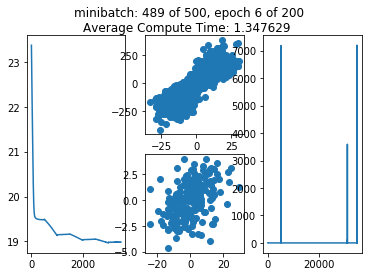

weight update time: 0.108038
weight update time: 0.047357


In [ ]:
(H, Sig_H), (W,Sig_W), (V,Sig_V), max_h, max_w, max_v, Ls, _H_perm = fit(_H, _V, _W, num_hidden,.1, alpha_p, alpha_h)

In [ ]:
data_h = _H_perm.dot(_W).flatten()
data_v = _H_perm.dot(_V).flatten()
pred_h = H.dot(W).flatten()
pred_v = H.dot(V).flatten()
plt.scatter(data_h,pred_h)
plt.show()
plt.scatter(data_v,pred_v)

In [ ]:
plt.scatter(range(len(max_h)),max_w, color='blue')
plt.scatter(range(len(max_h)),max_v, color='red')
plt.scatter(range(len(max_h)),max_h, color='green')

In [ ]:
n=-1
clip = None
plt.plot(range(len(Ls[:n])),map(lambda x: x if not clip else min(x,clip),Ls[:n]))

##### 